In [1]:
import time
start_time = time.time()

In [2]:
import logging
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.spatial.distance import cdist
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

from stein_thinning.thinning import thin_gf

import lotka_volterra
from thinning import gaussian_thin, laplace_approximation
import utils.caching
from utils.caching import make_cached
from utils.parallel import get_map_parallel_joblib
from utils.paths import GENERATED_DATA_PATH
from utils.plotting import highlight_points

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
cached = make_cached(GENERATED_DATA_PATH)

In [6]:
map_parallel = get_map_parallel_joblib(multiprocessing.cpu_count())

In [7]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

Read-only input datasets:

In [8]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_samples(i) -> np.ndarray:
    raise NotImplementedError

In [9]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_log_p(i) -> np.ndarray:
    raise NotImplementedError

# Gradient-free Stein thinning

In [10]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

## Sample with burn-in removed manually

We plot the difference in log-probability versus the squared Euclidean distance from the sample mode:

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/rw_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_log_p_0
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/rw_log_p_0.npy


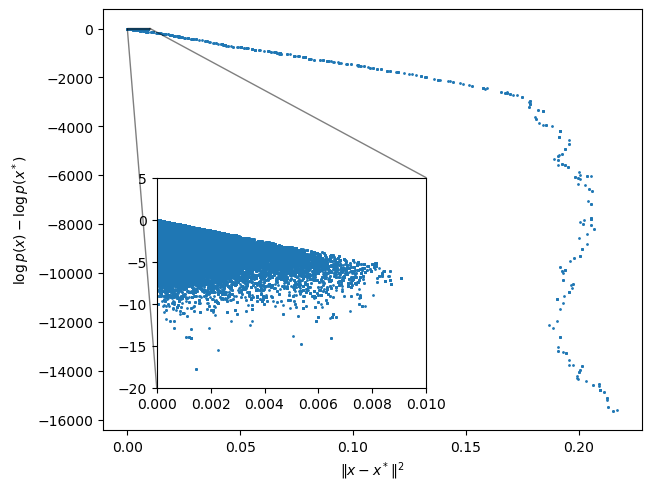

In [11]:
i = 0
sample = rw_samples[i]
sample_mean = np.mean(sample, axis=0)
ref_idx = np.argmax(rw_log_p[i])
dists = cdist(sample[ref_idx].reshape(1, -1), sample).squeeze()
prob_diff = rw_log_p[i] - rw_log_p[i][ref_idx]

fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(dists ** 2, prob_diff, s=1);
ax.set_xlabel('$\\|x - x^* \\|^2$');
ax.set_ylabel('$\\log p(x) - \\log p(x^*)$');

inset_xlim = [0, 0.01]
inset_ylim = [-20, 5]

ax_ins = ax.inset_axes([0.1, 0.1, 0.5, 0.5], xlim=inset_xlim, ylim=inset_ylim)
ax.indicate_inset_zoom(ax_ins, edgecolor="black")

ax_ins.scatter(dists ** 2, prob_diff, s=1);
ax_ins.set_xlim(inset_xlim);
ax_ins.set_ylim(inset_ylim);

We can us the threshold of -15 to locate the bulk of the sample.

In [12]:
cond = prob_diff > -15 

This retains most of the points:

In [13]:
np.sum(cond) / rw_samples[0].shape[0]

np.float64(0.9985880028239944)

The resulting subsample:

In [14]:
subsample = rw_samples[0][cond]
subsample_log_p = rw_log_p[0][cond]

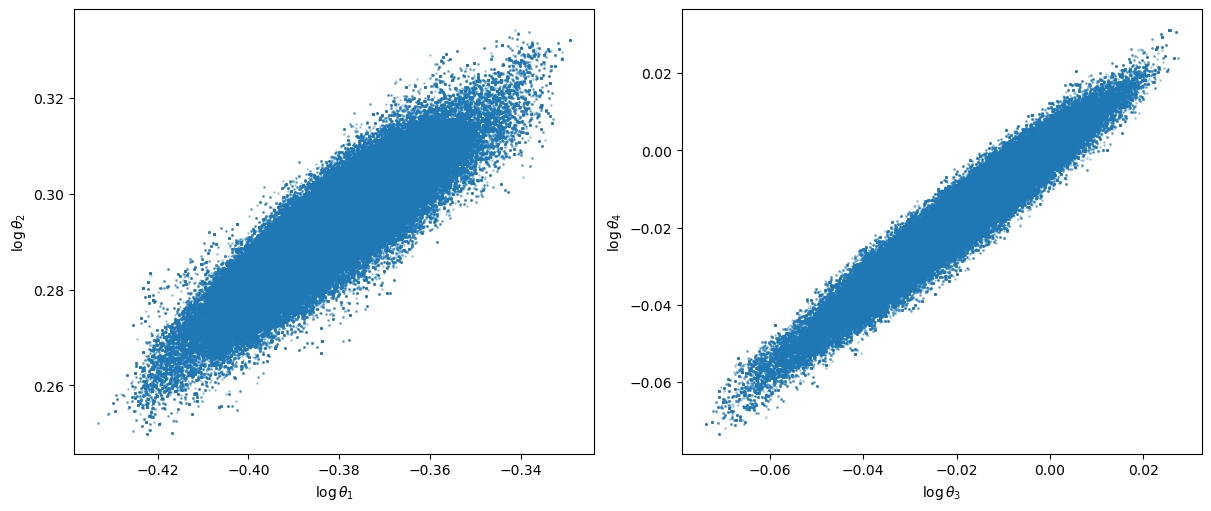

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(subsample, [], [(0, 1), (2, 3)], axs, var_labels, sample_point_color=None);

### Laplace proxy

The parameters of the Laplace proxy do not change, since they are estimated from the posterior distribution rather than the sample.

Thinning fails in this case again:

In [16]:
%%time
laplace_mean, laplace_cov = laplace_approximation(lotka_volterra.log_target_density, np.mean(rw_samples[0], axis=0))

CPU times: user 317 ms, sys: 61 μs, total: 317 ms
Wall time: 326 ms


In [17]:
gaussian_thin(subsample, subsample_log_p, laplace_mean, laplace_cov, n_points_thinned)

array([216253, 288880, 325875, 148608, 367029,  83076, 255004, 417664,
          589, 117012, 272328, 130467,  62040, 412078, 164272, 378878,
       219276, 300091, 110814, 158320], dtype=uint32)

In [18]:
subsample_log_p[426876]

np.float64(844.9508392810932)

In [19]:
subsample_log_q = mvn.logpdf(subsample, mean=laplace_mean, cov=laplace_cov)

In [20]:
subsample_log_q[426876]

np.float64(10.653573006398148)

Again, the tail of the proxy distribution is too thin relative to the target.

### Gaussian proxy

In [21]:
subsample_mean = np.mean(subsample, axis=0)
subsample_cov = np.cov(subsample, rowvar=False, ddof=lotka_volterra.d)

In [22]:
subsample_mean

array([-0.3825417 ,  0.29205248, -0.02000333, -0.01804386])

In [23]:
subsample_cov

array([[ 0.00020368,  0.0001405 , -0.00020228, -0.0001877 ],
       [ 0.0001405 ,  0.00012273, -0.00013094, -0.00011424],
       [-0.00020228, -0.00013094,  0.00020522,  0.00019451],
       [-0.0001877 , -0.00011424,  0.00019451,  0.00019704]])

The values calculated from the subsample are very close to those obtained from the full sample:

In [24]:
sample_mean

array([-0.38261842,  0.29176476, -0.02010969, -0.01824518])

In [25]:
subsample_cov

array([[ 0.00020368,  0.0001405 , -0.00020228, -0.0001877 ],
       [ 0.0001405 ,  0.00012273, -0.00013094, -0.00011424],
       [-0.00020228, -0.00013094,  0.00020522,  0.00019451],
       [-0.0001877 , -0.00011424,  0.00019451,  0.00019704]])

In [26]:
idx = gaussian_thin(subsample, subsample_log_p, subsample_mean, subsample_cov, n_points_thinned)
idx

array([389851, 148608,  79802, 465262, 308570, 180846, 155850, 319708,
       287258, 308583, 488658, 164272, 153967, 292106, 308570, 308442,
        71864, 315307,  60808, 322851], dtype=uint32)

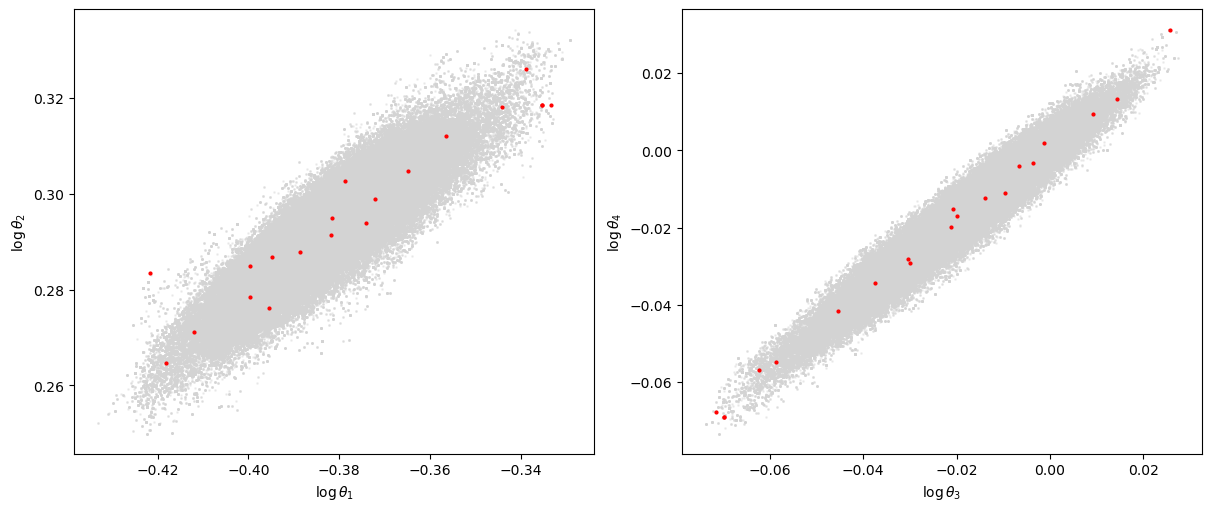

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(subsample, idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

Notebook execution took:

In [28]:
time.time() - start_time

14.394981622695923